# Data 620 - Project 3

Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen

## Project description

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

## Load libraries.

In [1]:
import random
from collections import Counter
import nltk
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data loading/preparation

In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from which we should be able to create numerous features from.

### Load and shuffle data.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
#download('names')
males = [(name.lower().strip(), 'male') for name in names.words('male.txt')]
females = [(name.lower().strip(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

# randomize the list
random.seed(13)
random.shuffle(all_names)

### Feature creation

Features are the most important part of what goes into a machine learning model. For that reason, it is critically important to try to come up with features that make the most sense in identifying gender differences in names. To make creation and analysis easier, we will put our data in a Pandas dataframe.

In [3]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,uriel,male
1,brett,female
2,neel,male
3,phedra,female
4,maridel,female


In [4]:
# instatiate syllable tokenize
SSP = SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(SSP.tokenize(x)))

# preview data
data.head()

/Users/hmgeiger/Library/Python/3.7/lib/python/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c))


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
0,uriel,male,5,u,l,False,True,uie,rl,3,2,"[(u, r), (r, i), (i, e), (e, l)]","[(u, r, i), (r, i, e), (i, e, l)]",2
1,brett,female,5,b,t,False,False,e,brtt,1,4,"[(b, r), (r, e), (e, t), (t, t)]","[(b, r, e), (r, e, t), (e, t, t)]",1
2,neel,male,4,n,l,False,False,ee,nl,2,2,"[(n, e), (e, e), (e, l)]","[(n, e, e), (e, e, l)]",1
3,phedra,female,6,p,a,True,False,ea,phdr,2,4,"[(p, h), (h, e), (e, d), (d, r), (r, a)]","[(p, h, e), (h, e, d), (e, d, r), (d, r, a)]",2
4,maridel,female,7,m,l,False,False,aie,mrdl,3,4,"[(m, a), (a, r), (r, i), (i, d), (d, e), (e, l)]","[(m, a, r), (a, r, i), (r, i, d), (i, d, e), (...",3


In [5]:
# lets analyze our bigrams and trigrams columns to get the most common ngrams by gender
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(b, r), (r, e), (e, t), (t, t), (p, h), (h, e...","[(b, r, e), (r, e, t), (e, t, t), (p, h, e), (...","{('b', 'r'): 84, ('r', 'e'): 289, ('e', 't'): ...","{('b', 'r', 'e'): 14, ('r', 'e', 't'): 42, ('e..."
male,"[(u, r), (r, i), (i, e), (e, l), (n, e), (e, e...","[(u, r, i), (r, i, e), (i, e, l), (n, e, e), (...","{('u', 'r'): 65, ('r', 'i'): 205, ('i', 'e'): ...","{('u', 'r', 'i'): 10, ('r', 'i', 'e'): 21, ('i..."


Using the counter class and the bigrams and trigrams, we can eliminate the need for the most common bigram/trigram and instead just use the list of bigrams and trigrams as features. The most common bigram was only in ~13% of the female names and ~12% of the male names.

## Data exploration

Lets get a better feel for how our data is composed. In this exploration step, we will confirm whether any of the features we created will become good predictors of gender. Exploration will occur both visually as well as computationally.

In [6]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.148294,0.723061,0.174560,2.676525,3.471768,2.474043
male,5.942701,0.234672,0.154745,2.199270,3.743431,2.048540


In [7]:
# separate features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel. These appear to be good predictors. We need to visual confirm what we see numerically.

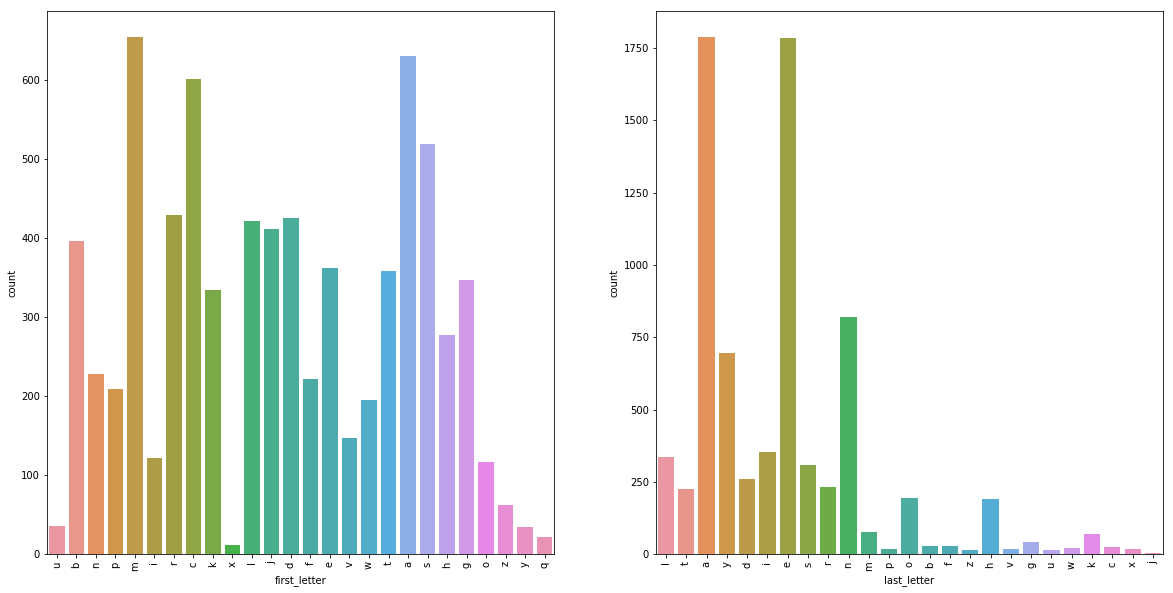

In [8]:
# categorical/numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

The distributions above don't tell us much. We need to condition on gender.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


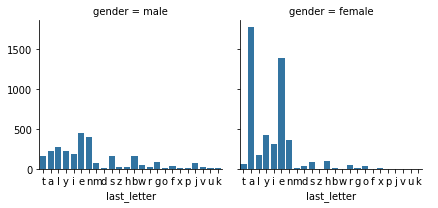

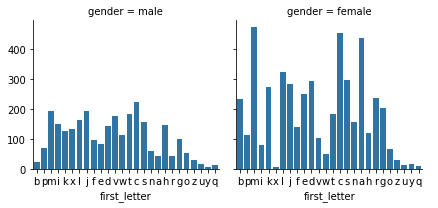

In [9]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'last_letter').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'first_letter').add_legend()
plt.tight_layout()
plt.show()

It would appear that both the first and the last letter could be pretty good predictors for gender.

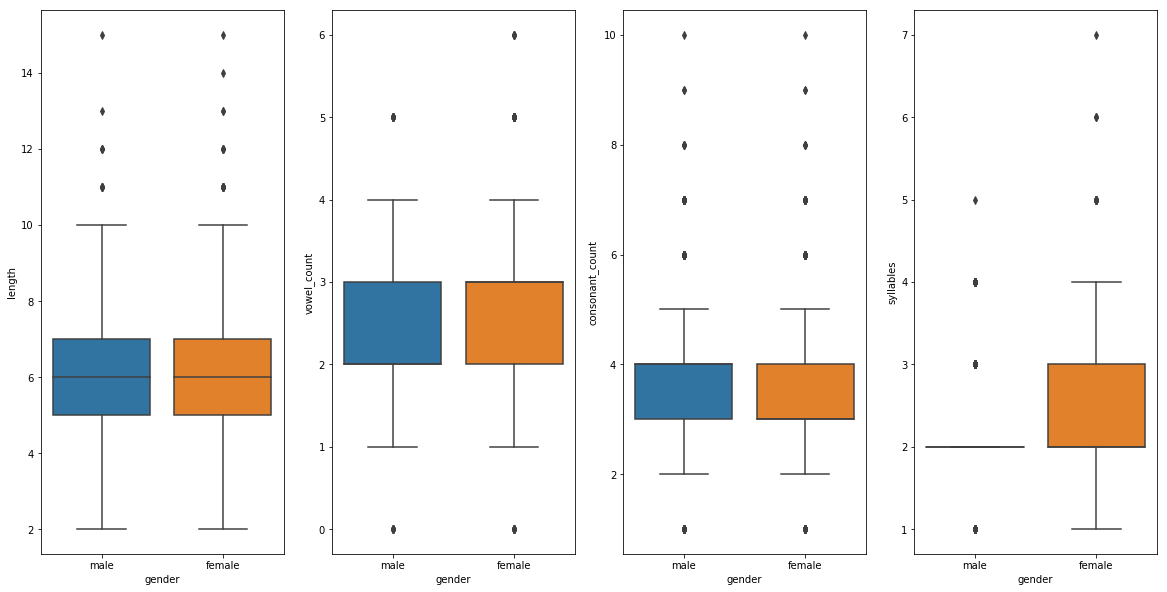

In [10]:
# numerical columns to gender exploration
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)

Baron had said: from the boxplots above, we can safely rule out vowel count, consonant count, and length as strong predictors of gender. Syllables, however, seems like it may be a good predictor.

However, I am wondering if boxplots are necessarily the best way to look at these variables, as they are integers with a fairly narrow range.

Let's try a conditional plot for each of these variables like we did for first and last letter.

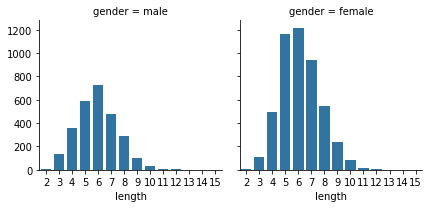

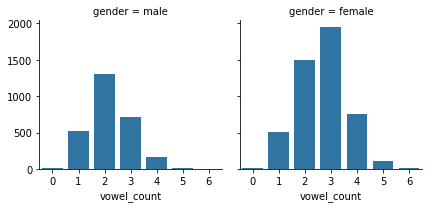

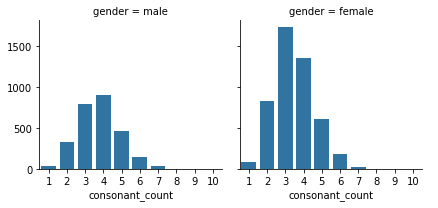

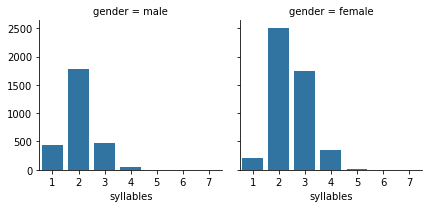

In [11]:
cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'length').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'vowel_count').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'consonant_count').add_legend()
plt.tight_layout()
plt.show()

cond_plot = sns.FacetGrid(data=data, col='gender')
cond_plot.map(sns.countplot, 'syllables').add_legend()
plt.tight_layout()
plt.show()

Looks like the conclusion still mostly holds that we can exclude length, vowel count, and consonant count.

## Feature generation

### Feature generation function

This function will be applied to our lists of names to create the features that we identified as potential predictors above in our initial model "kitchen sink" approach. As we refine the model we will also refine this function to include only the features that seem most relevant to our classifier. Vowel count, consonant count, and length have already been removed since they were found above to have no predictive value.

In [12]:
# feature generator
def gender_features(name):
    # length of name
    #length = len(name)
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowel/consonants + counts
    #vowels = name.replace(r'[^aeiou]', '')
    vowels = tuple([l for l in name if l in ['a','e','i','o','u']])
    #vowel_count = len(vowels)
    #consonants = name.replace(r'[aeiou]', '')
    consonants = tuple([l for l in name if l not in ['a','e','i','o','u']])
    #consonant_count = len(consonants)
    
    # bigrams/trigrams
    bigrams = tuple(ngrams(name, 2)) #This used to be list instead of tuple, but got an error about them being unhashable. Solved by using tuple instead.
    trigrams = tuple(ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        #'length': length,
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        #'vowel_count': vowel_count,
        'consonants': consonants,
        #'consonant_count': consonant_count,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

### Training/test split and apply feature generation function.

In [13]:
# create each set of data
final_test = all_names[:500]
training_and_dev_test = all_names[-7400:]

#Shuffle the training + dev test data, then separate.
#We are doing it this way so we can redo this as we refine the model.
random.shuffle(training_and_dev_test)
dev_test = training_and_dev_test[:500]
training = training_and_dev_test[500:]

# apply feature generation function
dev_test_features = [(gender_features(name), gender) for name, gender in dev_test]
training_features = [(gender_features(name), gender) for name, gender in training]

## Apply model.

### Initial model

Now that we have all our features and have run training/test split, we are ready to apply the model.

In [14]:
classifier = nltk.MaxentClassifier.train(training_features,trace=1)

  ==> Training (100 iterations)


Look at the accuracy on the training data, just as a sanity check.

In [15]:
nltk.classify.accuracy(classifier, training_features)

0.9588405797101449

Accuracy on the training data is very high, which is good.

Let's also look at accuracy for the initial test data, again just as a sanity check.

In [16]:
nltk.classify.accuracy(classifier, dev_test_features)

0.782

We will want to play around with which features to include or exclude to see if we can improve the accuracy here, as this accuracy score on the test data really isn't the best.

But this is a good start!

### Refining the model

Let's work on seeing if we should remove features (or possibly add new features) to improve accuracy.

Start by examining the errors, similar to what was done in the textbook.

In [17]:
errors = []

for (name,tag) in dev_test:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))

In [18]:
for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))

correct=female   guess=male     name=aigneis                       
correct=female   guess=male     name=ajay                          
correct=female   guess=male     name=alfie                         
correct=female   guess=male     name=ali                           
correct=female   guess=male     name=andrea                        
correct=female   guess=male     name=angie                         
correct=female   guess=male     name=aubrey                        
correct=female   guess=male     name=bel                           
correct=female   guess=male     name=bernie                        
correct=female   guess=male     name=bridget                       
correct=female   guess=male     name=calypso                       
correct=female   guess=male     name=carrol                        
correct=female   guess=male     name=claire                        
correct=female   guess=male     name=dagmar                        
correct=female   guess=male     name=debor      

We see some of what they saw in the textbook example, where we may want to add a feature for the last two letters.

We also see, which the textbook did not mention, that there are a fair number of unisex names in this data set.

For example, "willy" is listed as both a male and female name. So it is not surprising that the classifier did not guess this as a female name.

Anyway, let's try adding a "suffix2" feature and see if that improves accuracy.

Run using both the same and a different training and dev test set.

In [19]:
# feature generator
def gender_features(name):
    # length of name
    #length = len(name)
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowel/consonants + counts
    #vowels = name.replace(r'[^aeiou]', '')
    vowels = tuple([l for l in name if l in ['a','e','i','o','u']])
    #vowel_count = len(vowels)
    #consonants = name.replace(r'[aeiou]', '')
    consonants = tuple([l for l in name if l not in ['a','e','i','o','u']])
    #consonant_count = len(consonants)
    
    # bigrams/trigrams
    bigrams = tuple(ngrams(name, 2)) #This used to be list instead of tuple, but got an error about them being unhashable. Solved by using tuple instead.
    trigrams = tuple(ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        #'length': length,
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        #'vowel_count': vowel_count,
        'consonants': consonants,
        #'consonant_count': consonant_count,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [20]:
dev_test_features = [(gender_features(name), gender) for name, gender in dev_test]
training_features = [(gender_features(name), gender) for name, gender in training]

random.shuffle(training_and_dev_test)
dev_test2 = training_and_dev_test[:500]
training2 = training_and_dev_test[500:]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

In [21]:
classifier1 = nltk.MaxentClassifier.train(training_features,trace=1)
classifier2 = nltk.MaxentClassifier.train(training_features2,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [22]:
nltk.classify.accuracy(classifier1, training_features)
nltk.classify.accuracy(classifier1, dev_test_features)

nltk.classify.accuracy(classifier2, training_features2)
nltk.classify.accuracy(classifier2, dev_test_features2)

0.9588405797101449

0.802

0.9582608695652174

0.806

We see the same ~2% improvement in accuracy that they got in the textbook.

We also see similar accuracy using two different randomly chosen training and test data sets.

Let's look at errors again. Use the second training/test split.

In [23]:
errors = []

for (name,tag) in dev_test2:
    guess = classifier2.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))       
        
for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))        

correct=female   guess=male     name=abbie                         
correct=female   guess=male     name=agnes                         
correct=female   guess=male     name=ajay                          
correct=female   guess=male     name=allyson                       
correct=female   guess=male     name=amber                         
correct=female   guess=male     name=andy                          
correct=female   guess=male     name=avis                          
correct=female   guess=male     name=bab                           
correct=female   guess=male     name=billy                         
correct=female   guess=male     name=blair                         
correct=female   guess=male     name=brooks                        
correct=female   guess=male     name=carmine                       
correct=female   guess=male     name=cinnamon                      
correct=female   guess=male     name=daloris                       
correct=female   guess=male     name=dennie     

Nothing is jumping out at me this time.

Let's look at bigrams in names incorrectly labeled as male (actually female) and vice versa.

In [24]:
bigrams_actually_opposite = [list(ngrams(name,2)) for tag,guess,name in sorted(errors) if tag == "female"]
bigrams_actually_opposite = [item for sublist in bigrams_actually_opposite for item in sublist]
bigrams_actually_opposite_count = Counter(bigrams_actually_opposite)
[(l,k) for k,l in sorted([(j,i) for i,j in bigrams_actually_opposite_count.items()],reverse=True)]

[(('r', 'i'), 4),
 (('n', 'n'), 4),
 (('n', 'i'), 4),
 (('i', 's'), 4),
 (('i', 'n'), 4),
 (('h', 'e'), 4),
 (('t', 'h'), 3),
 (('o', 'n'), 3),
 (('n', 'e'), 3),
 (('l', 'y'), 3),
 (('l', 'o'), 3),
 (('i', 'r'), 3),
 (('e', 'n'), 3),
 (('e', 'l'), 3),
 (('a', 'r'), 3),
 (('a', 'm'), 3),
 (('a', 'l'), 3),
 (('v', 'i'), 2),
 (('r', 'o'), 2),
 (('o', 'r'), 2),
 (('n', 'd'), 2),
 (('m', 'i'), 2),
 (('m', 'a'), 2),
 (('l', 'l'), 2),
 (('l', 'a'), 2),
 (('k', 'i'), 2),
 (('j', 'e'), 2),
 (('i', 'l'), 2),
 (('i', 'e'), 2),
 (('i', 'a'), 2),
 (('g', 'l'), 2),
 (('e', 't'), 2),
 (('e', 's'), 2),
 (('e', 'r'), 2),
 (('d', 'i'), 2),
 (('d', 'e'), 2),
 (('d', 'a'), 2),
 (('b', 'i'), 2),
 (('a', 'n'), 2),
 (('a', 'b'), 2),
 (('z', 'y'), 1),
 (('z', 'o'), 1),
 (('y', 's'), 1),
 (('y', 'n'), 1),
 (('v', 'y'), 1),
 (('u', 'z'), 1),
 (('u', 's'), 1),
 (('u', 'r'), 1),
 (('s', 'u'), 1),
 (('s', 't'), 1),
 (('s', 's'), 1),
 (('s', 'o'), 1),
 (('r', 'n'), 1),
 (('r', 'm'), 1),
 (('r', 'l'), 1),
 (('r', 'g

In [25]:
bigrams_actually_opposite = [list(ngrams(name,2)) for tag,guess,name in sorted(errors) if tag == "male"]
bigrams_actually_opposite = [item for sublist in bigrams_actually_opposite for item in sublist]
bigrams_actually_opposite_count = Counter(bigrams_actually_opposite)
[(l,k) for k,l in sorted([(j,i) for i,j in bigrams_actually_opposite_count.items()],reverse=True)]

[(('n', 'e'), 8),
 (('a', 'r'), 8),
 (('r', 'i'), 7),
 (('r', 'e'), 7),
 (('l', 'e'), 7),
 (('i', 'e'), 7),
 (('o', 'r'), 5),
 (('l', 'l'), 5),
 (('h', 'a'), 5),
 (('e', 'r'), 5),
 (('a', 'n'), 5),
 (('s', 't'), 4),
 (('i', 'n'), 4),
 (('e', 'n'), 4),
 (('e', 'l'), 4),
 (('e', 'a'), 4),
 (('c', 'h'), 4),
 (('a', 'l'), 4),
 (('a', 'i'), 4),
 (('v', 'i'), 3),
 (('t', 'e'), 3),
 (('s', 'i'), 3),
 (('r', 'l'), 3),
 (('j', 'o'), 3),
 (('i', 'a'), 3),
 (('g', 'e'), 3),
 (('a', 'd'), 3),
 (('t', 'i'), 2),
 (('t', 'a'), 2),
 (('s', 'k'), 2),
 (('s', 'h'), 2),
 (('r', 'r'), 2),
 (('r', 'n'), 2),
 (('r', 'a'), 2),
 (('p', 'a'), 2),
 (('o', 't'), 2),
 (('o', 's'), 2),
 (('m', 'o'), 2),
 (('m', 'a'), 2),
 (('k', 'i'), 2),
 (('i', 's'), 2),
 (('i', 'm'), 2),
 (('h', 'e'), 2),
 (('f', 'r'), 2),
 (('f', 'f'), 2),
 (('e', 'y'), 2),
 (('d', 'r'), 2),
 (('d', 'e'), 2),
 (('c', 'o'), 2),
 (('c', 'e'), 2),
 (('b', 'y'), 2),
 (('b', 'r'), 2),
 (('b', 'i'), 2),
 (('a', 'u'), 2),
 (('a', 'b'), 2),
 (('z', 'a

Let's try adding a first two letters feature, since adding a last two letters feature was so helpful.

Hoping that will resolve some new issues we are seeing now, like names ending in "ne" sometimes being classified incorrectly as female instead of male.

In [26]:
# feature generator
def gender_features(name):
    # length of name
    #length = len(name)
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    first_two_letters = name[0:2]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowel/consonants + counts
    #vowels = name.replace(r'[^aeiou]', '')
    vowels = tuple([l for l in name if l in ['a','e','i','o','u']])
    #vowel_count = len(vowels)
    #consonants = name.replace(r'[aeiou]', '')
    consonants = tuple([l for l in name if l not in ['a','e','i','o','u']])
    #consonant_count = len(consonants)
    
    # bigrams/trigrams
    bigrams = tuple(ngrams(name, 2)) #This used to be list instead of tuple, but got an error about them being unhashable. Solved by using tuple instead.
    trigrams = tuple(ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        #'length': length,
        'first_letter': first_letter,
        'first_two_letters': first_two_letters,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        #'vowel_count': vowel_count,
        'consonants': consonants,
        #'consonant_count': consonant_count,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [27]:
dev_test_features = [(gender_features(name), gender) for name, gender in dev_test]
training_features = [(gender_features(name), gender) for name, gender in training]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

random.shuffle(training_and_dev_test)
dev_test3 = training_and_dev_test[:500]
training3 = training_and_dev_test[500:]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

In [28]:
classifier1v2 = nltk.MaxentClassifier.train(training_features,trace=1)
classifier2v2 = nltk.MaxentClassifier.train(training_features2,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)


In [29]:
classifier3 = nltk.MaxentClassifier.train(training_features3,trace=1)

  ==> Training (100 iterations)


In [30]:
nltk.classify.accuracy(classifier1v2, training_features)
nltk.classify.accuracy(classifier1v2, dev_test_features)

nltk.classify.accuracy(classifier2v2, training_features2)
nltk.classify.accuracy(classifier2v2, dev_test_features2)

nltk.classify.accuracy(classifier3, training_features3)
nltk.classify.accuracy(classifier3, dev_test_features3)

0.9588405797101449

0.81

0.9582608695652174

0.796

0.9595652173913043

0.806

Looks like this feature causes performance to be at most slightly better, and possibly even a bit worse.

And I can't think of any other features that would be good to add, or that should be removed from the existing set.

So, let's go back to the classifier including last two letters, but excluding first two letters.

Then, train using a completely new training set.

Finally, report accuracy on the final test data.

In [36]:
# feature generator
def gender_features(name):
    # length of name
    #length = len(name)
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowel/consonants + counts
    #vowels = name.replace(r'[^aeiou]', '')
    vowels = tuple([l for l in name if l in ['a','e','i','o','u']])
    #vowel_count = len(vowels)
    #consonants = name.replace(r'[aeiou]', '')
    consonants = tuple([l for l in name if l not in ['a','e','i','o','u']])
    #consonant_count = len(consonants)
    
    # bigrams/trigrams
    bigrams = tuple(ngrams(name, 2)) #This used to be list instead of tuple, but got an error about them being unhashable. Solved by using tuple instead.
    trigrams = tuple(ngrams(name, 3))
    
    # syllables
    syllables = len(SSP.tokenize(name))
    
    return {
        #'length': length,
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        #'vowel_count': vowel_count,
        'consonants': consonants,
        #'consonant_count': consonant_count,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

In [37]:
random.shuffle(training_and_dev_test)
training4 = training_and_dev_test[500:]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

In [38]:
final_classifier = nltk.MaxentClassifier.train(training_features4,trace=1)

  ==> Training (100 iterations)


In [39]:
final_test_features = [(gender_features(name), gender) for name, gender in final_test]
nltk.classify.accuracy(final_classifier, final_test_features)

0.786